# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

### The Project
---
The goals / steps of this project are the following:
* Load the data set
* Explore, summarize and visualize the data set
* Design, train and test a model architecture
* Use the model to make predictions on new images
* Analyze the softmax probabilities of the new images
* Summarize the results with a written report


---
## Step 0: Import Required Libraries and Load The Data

In [2]:
## Import Project Required Libraries
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import cv2
import matplotlib.image as mpimg
import skimage.transform

# Visualizations will be shown in the notebook.
%matplotlib inline

In [3]:
# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
validation_file = 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Sanity Checks
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

For our project, we only need the 'features' and 'labels' keys, which we extracted earlier.

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [6]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = [np.min(y_train), np.max(y_train)]

print("Training Set:   {} samples".format(n_train))
print("Validation Set: {} samples".format(n_validation))
print("Test Set:       {} samples".format(n_test))
print("Number of classes: {} classes, {} -> {}".format(n_classes[1]+1, n_classes[0], n_classes[1]))
print("Image Data Shape: {}x{}x{}".format(image_shape[0], image_shape[1], image_shape[2]))

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples
Number of classes: 43 classes, 0 -> 42
Image Data Shape: 32x32x3


### Include an exploratory visualization of the dataset

We will visualize the German Traffic Signs Dataset using the pickled file(s). In this section we will be:
* Plotting four random traffic sign images along with their label
* Plotting the count of each sign
* Plotting distribution of classes in the training, validation and test sets.


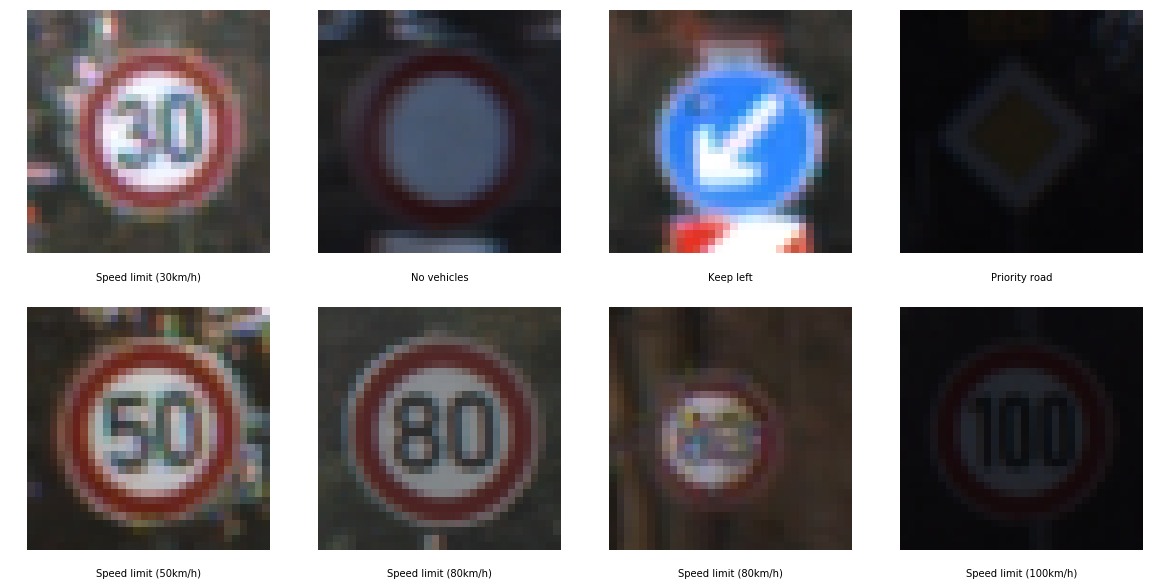

In [7]:
# Read CSV File for Sign Names
signNames = pd.read_csv('data/signnames.csv')

# Display Four Random Signs with their Respective Sign Names
plt.figure(figsize=(20, 10))
subPlotNum = 241
for i in range(8):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    ax = plt.subplot(subPlotNum)
    plt.imshow(image)
    plt.text(0.5, -0.1, signNames.SignName.iloc[y_train[index]], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.axis('off')
    subPlotNum += 1

### Plotting the count of each sign

The following graph shows the count for each sign in the German Traffic Signs Database. It clearly shows that the distribution for each class is not equal, and that some classes (like class #1 or #2) are more than **ten times** the frequency of other classes (like class #0 or #19).

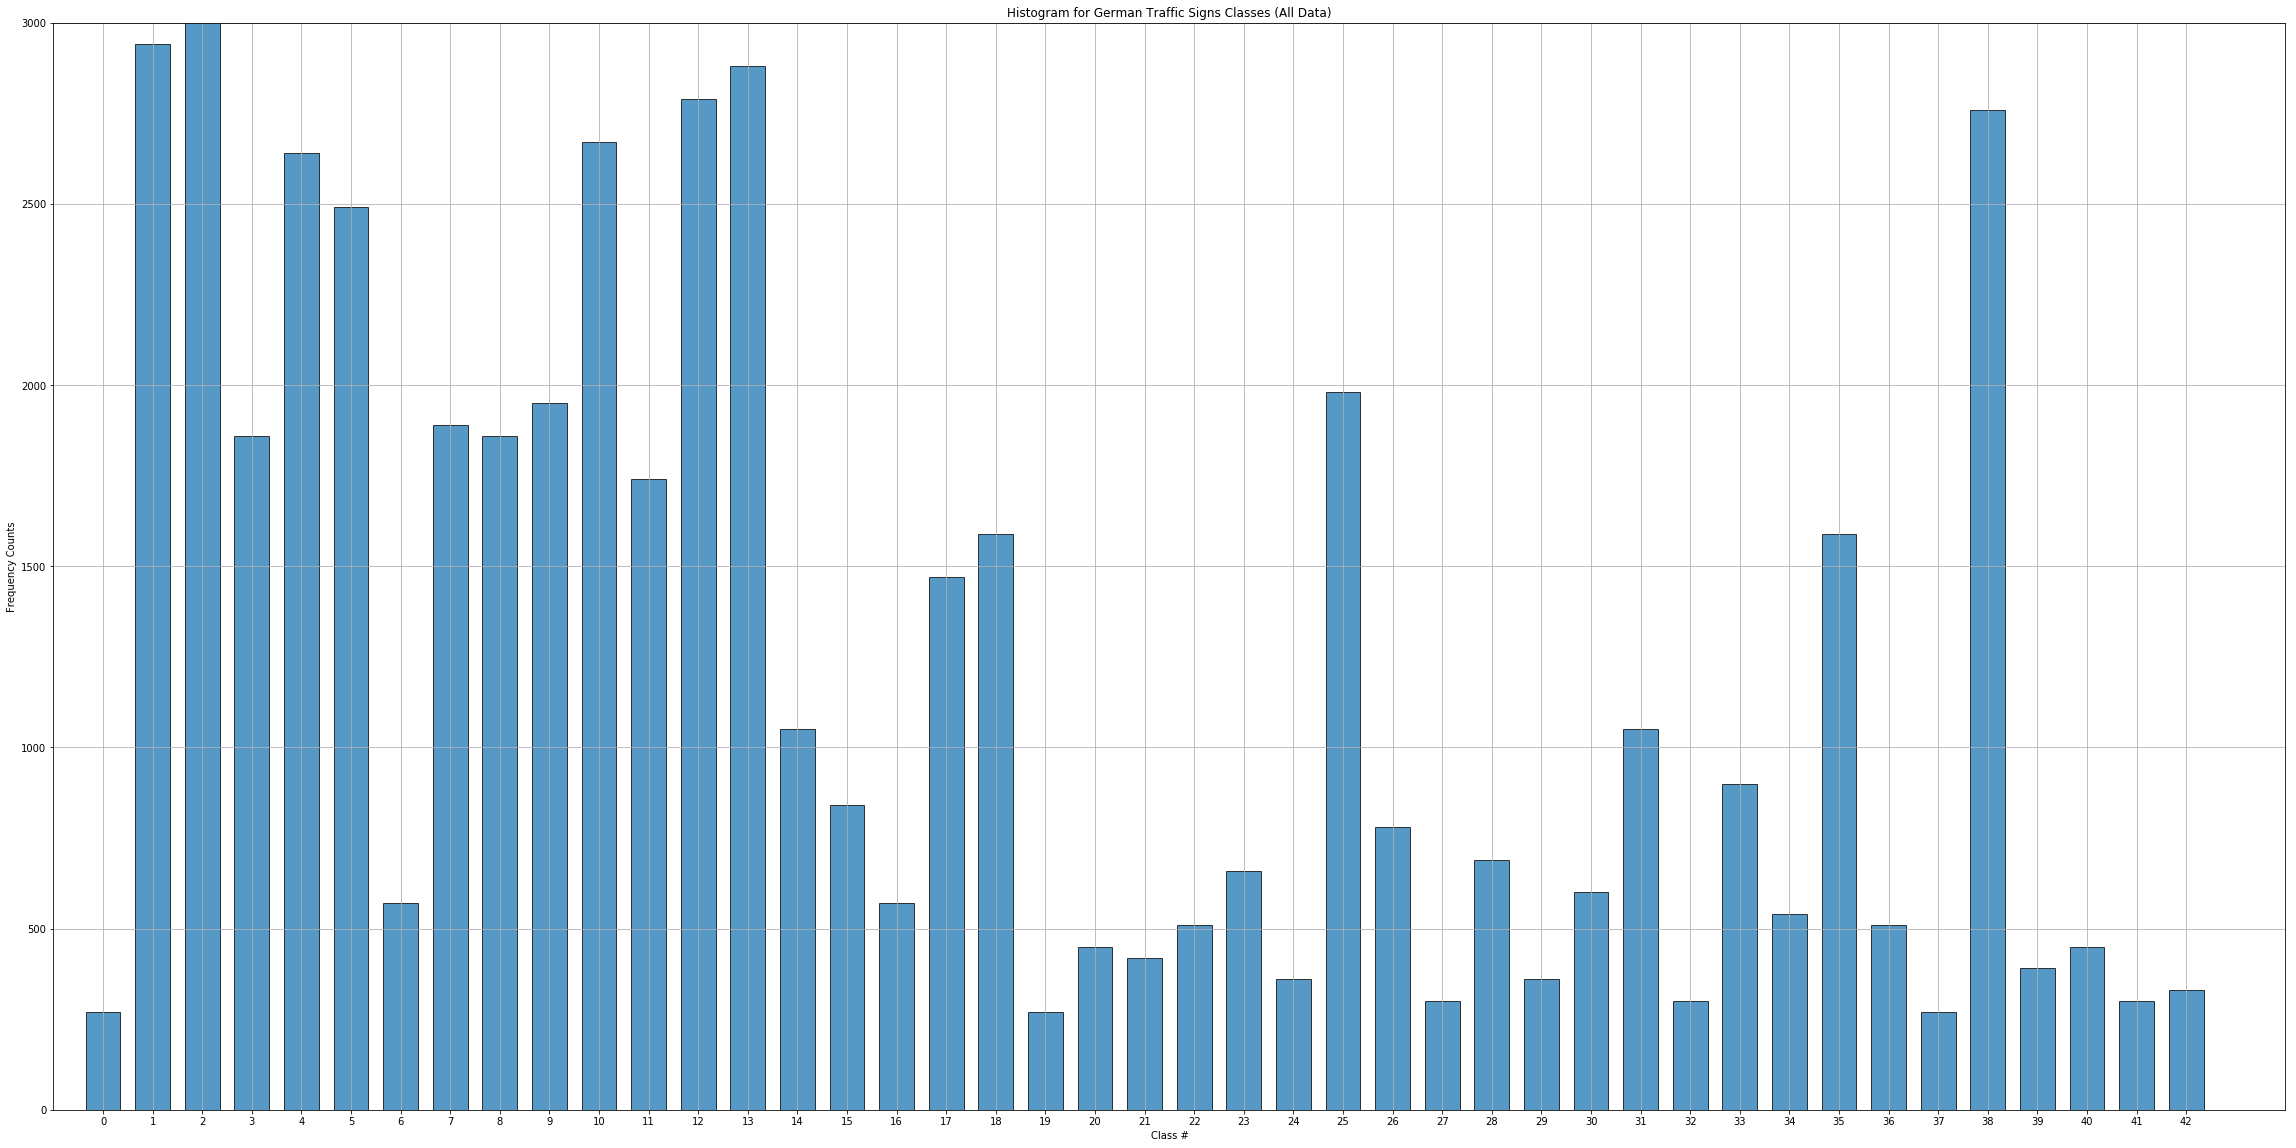

In [8]:
y_all = np.hstack(( y_train, y_valid, y_test )).ravel()

# Plot the Normalized Frequency of each Class
plt.figure(figsize=(40, 20))
plt.hist(y_all, bins=np.arange(44)-0.5, normed=0, alpha=0.75, histtype='bar', ec='black', rwidth=0.7)
plt.xlabel('Class #')
plt.ylabel('Frequency Counts')
plt.title('Histogram for German Traffic Signs Classes (All Data)')
plt.xticks(range(0,43))
plt.axis([-1, 44, 0, 3000])
plt.grid(True)
plt.show()

### Plotting distribution of classes in the training, validation and test set.

The following graph shows the normalized histograms for the training, validation, and test sets as well as all data combined. As shown from before, it is clear that the frequency of each class is not equal to other classes.

In addition, the graph shows that the training, validation, and test sets have been properly created, as their distribution looks similar.

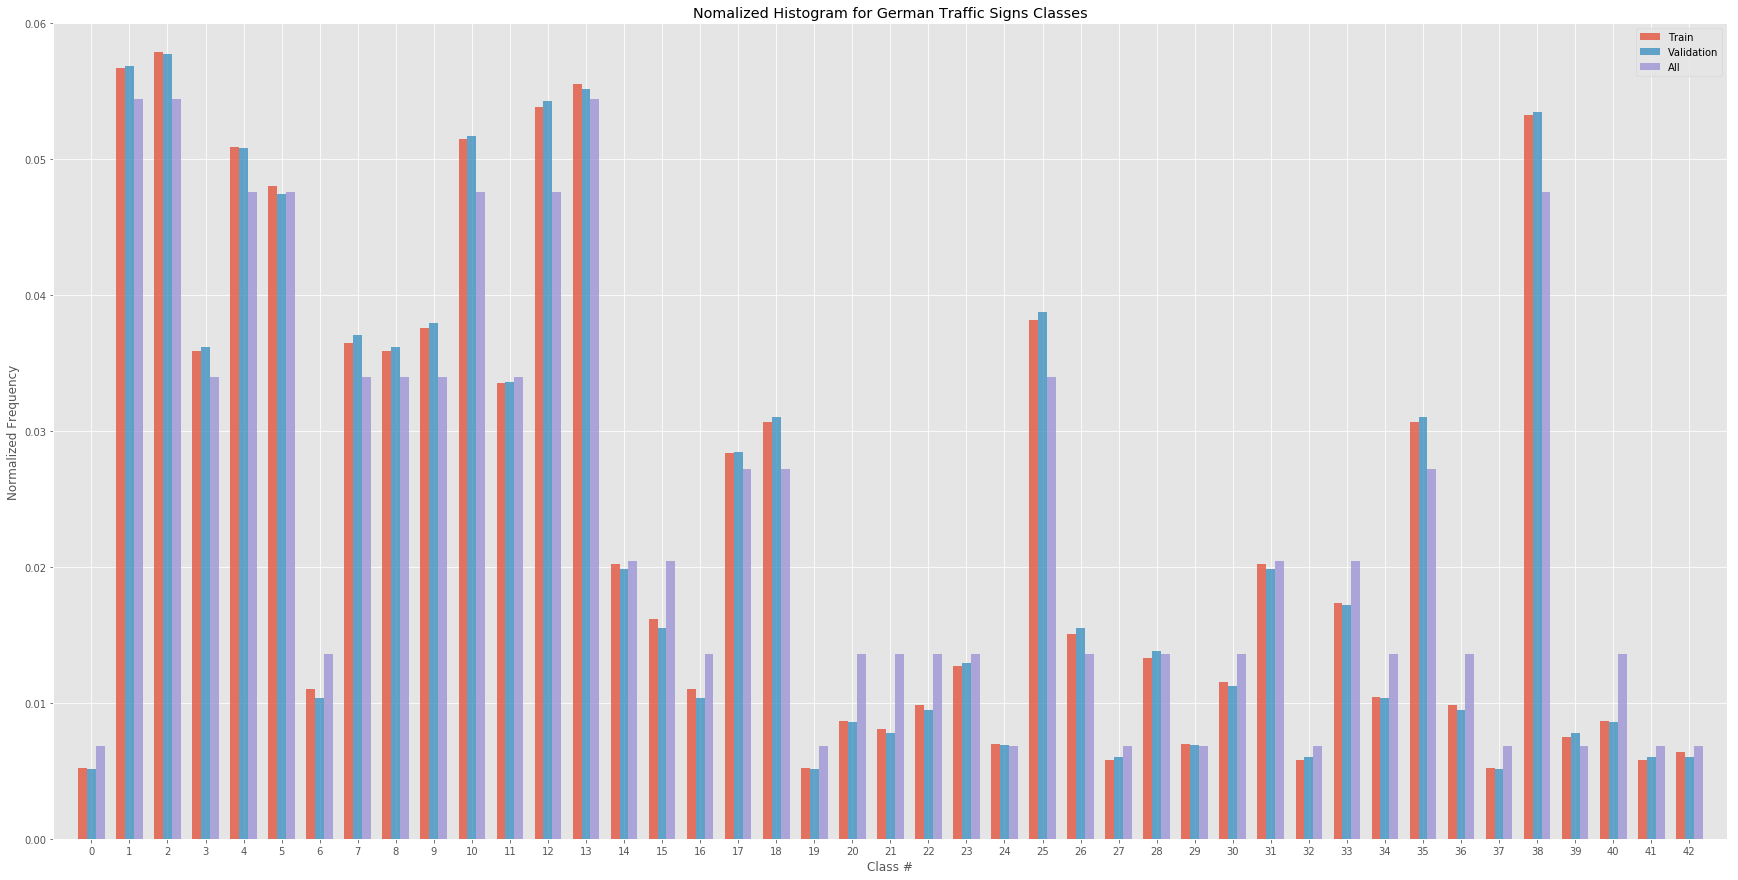

In [9]:
# Plot the Normalized Frequency of each Class
plt.figure(figsize=(30, 15))
plt.style.use('ggplot')
plt.hist([y_all, y_train, y_valid], bins=np.arange(44)-0.5, normed=1, alpha=0.75, label = ['Train', 'Validation', 'All'], rwidth=0.7)
plt.xlabel('Class #')
plt.ylabel('Normalized Frequency')
plt.title('Nomalized Histogram for German Traffic Signs Classes')
plt.xticks(range(0,43))
plt.axis([-1, 43, 0, 0.06])
plt.legend()
plt.grid(True)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

We will use the LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson. We'll change the number of classes and data preprocessing, but aside from that it's plug and play! 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

### Pre-process the Data Set (normalization, grayscale, etc.)

In [23]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to YUV, and shuffling the data.

# Normalize the data
X_train = np.float32(X_train) - 128.
X_train /= 128.

X_valid = np.float32(X_valid) - 128.
X_valid /= 128.

X_test = np.float32(X_test) - 128.
X_test /= 128.

# Convert images to YUV
for i in range(len(X_train)):
    X_train[i] = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2YUV)
    
for i in range(len(X_valid)):
    X_valid[i] = cv2.cvtColor(X_valid[i], cv2.COLOR_BGR2YUV)

for i in range(len(X_test)):
    X_test[i] = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2YUV)

# Shuffle Training Data
X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

In [5]:
### Define your architecture here.
EPOCHS = 979 # Found from previous runs
BATCH_SIZE = 128

def maxpool2d(x, k = 2, padding = 'VALID'):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding = padding)

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3 (Colored Images). Output = 28x28x6.
    weights_conv1 = tf.Variable(tf.truncated_normal(shape = (5,5,3,6), mean = mu, stddev = sigma))
    biases_conv1 = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, weights_conv1, strides = [1,1,1,1], padding = 'VALID') + biases_conv1

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)

    # Layer 2: Convolutional. Output = 10 x 10 x 16.
    weights_conv2 = tf.Variable(tf.truncated_normal(shape = (5, 5, 6, 16), mean = mu, stddev = sigma))
    biases_conv2 = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, weights_conv2, strides = [1,1,1,1], padding = 'VALID') + biases_conv2
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)

    # Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    weights_fc1 = tf.Variable(tf.truncated_normal(shape = (400, 120), mean = mu, stddev = sigma))
    biases_fc1 = tf.Variable(tf.zeros(120))
    fc1 = tf.add(tf.matmul(fc1, weights_fc1), biases_fc1)
    
    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    weights_fc2 = tf.Variable(tf.truncated_normal(shape = (120, 84), mean = mu, stddev = sigma))
    biases_fc2 = tf.Variable(tf.zeros(84))
    fc2 = tf.add(tf.matmul(fc1, weights_fc2), biases_fc2)
    
    # Activation.
    fc2 = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    weights_fc3 = tf.Variable(tf.truncated_normal(shape = (84, 43), mean = mu, stddev = sigma))
    biases_fc3 = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(fc2, weights_fc3), biases_fc3)
    
    return logits

In [6]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [7]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [12]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
history = {'train_accuracy': [], 'validation_accuracy': []}
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_accuracy *= 100
        history['validation_accuracy'].append(validation_accuracy)
        train_accuracy = evaluate(X_train, y_train)
        train_accuracy *= 100
        history['train_accuracy'].append(train_accuracy)
    saver.save(sess, 'models/lenet')
    print("Model saved")


Training...

Model saved


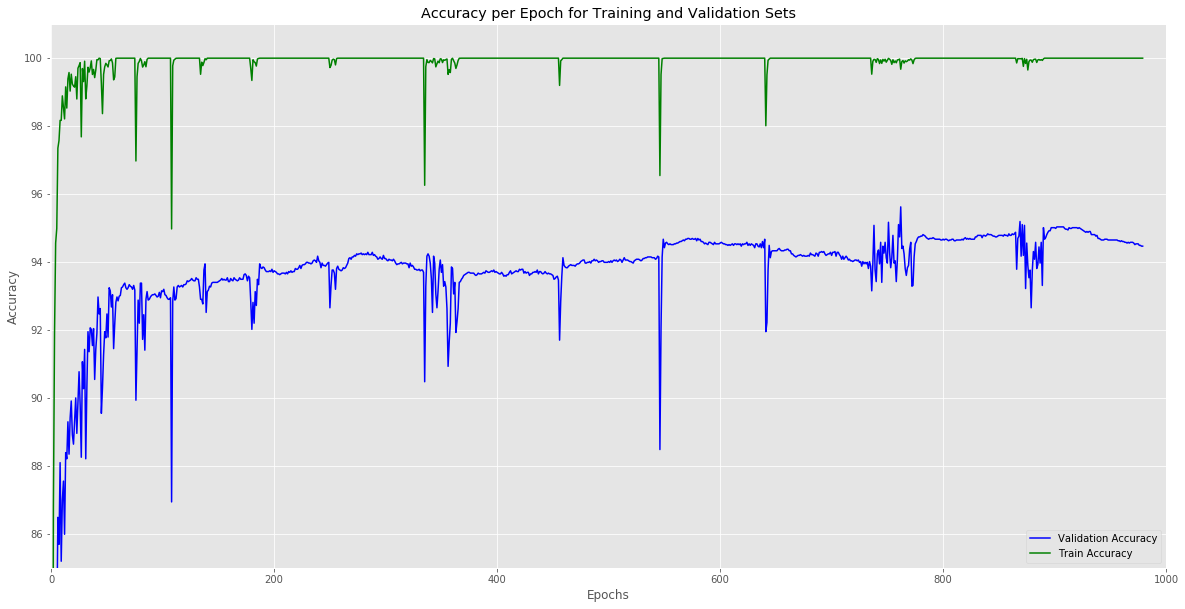

Best Train Accuracy: 100.00% at Epoch Number: 42
Best Validation Accuracy: 95.62% at Epoch Number: 761


In [13]:
# Plot the ACcuracy per Epoch
plt.figure(0, figsize=(20,10))
plt.style.use('ggplot')
plt.axis([-1, 1000, 85, 101])
plt.grid(True)
plt.plot(range(1, EPOCHS + 1), history['validation_accuracy'], 'b', label = 'Validation Accuracy')
plt.plot(range(1, EPOCHS + 1), history['train_accuracy'], 'g', label = 'Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch for Training and Validation Sets')
plt.legend()
plt.show()

max_acc_indx_train = np.where(history['train_accuracy'] == np.max(history['train_accuracy']))
max_acc_indx_valid = np.where(history['validation_accuracy'] == np.max(history['validation_accuracy']))
print('Best Train Accuracy: {:.2f}% at Epoch Number: {}'.format(np.max(history['train_accuracy']),
                                                                max_acc_indx_train[0][0]))
print('Best Validation Accuracy: {:.2f}% at Epoch Number: {}'.format(np.max(history['validation_accuracy']),
                                                                     max_acc_indx_valid[0][0]))

In [141]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('models/'))
    test_accuracy = evaluate(X_test, y_test)
    test_accuracy *= 100
    print("Test Accuracy = {:.2f}%".format(test_accuracy))

INFO:tensorflow:Restoring parameters from models/lenet
Test Accuracy = 93.17%


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

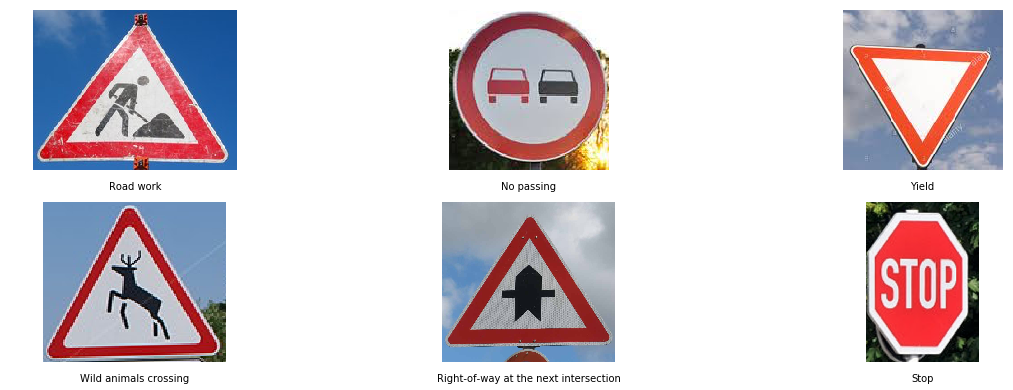

In [136]:
### Load the images and plot them here.
plt.figure(figsize=(20, 10))
subPlotNum = 331

webSignsY = [25, 9, 13, 31, 11, 14]
webSignsX = []
for i in range(1,7):
    img = mpimg.imread('data/Sign' + str(i) + '.tiff')
    imgProcessed = skimage.transform.resize(img, (32, 32), preserve_range= True, mode='reflect')
    imgProcessed = np.float32(imgProcessed) - 128.
    imgProcessed /= 128.
    imgProcessed = cv2.cvtColor(imgProcessed, cv2.COLOR_BGR2YUV)
    webSignsX.append(imgProcessed)
    ax = plt.subplot(subPlotNum)
    plt.imshow(img)
    plt.text(0.5, -0.1, signNames.SignName.iloc[webSignsY[i-1]], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.axis('off')
    subPlotNum += 1

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from models/lenet
Predicted Signs are: , [25], [41], [13], [31], [11], [14]


Below are the images and their predictions


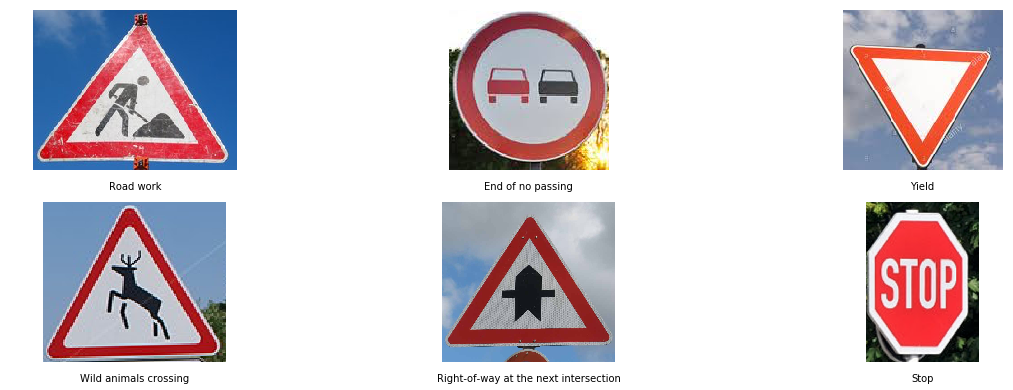

In [169]:
### Run the predictions here and use the model to output the prediction for each image.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('models/'))
    top = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k = 1), feed_dict={x : webSignsX})
    print('Predicted Signs are: ', *top.indices, sep = ', ')
plt.figure(figsize=(20, 10))
subPlotNum = 331
print('\n\nBelow are the images and their predictions')
for i in range(1,7):
    img = mpimg.imread('data/Sign' + str(i) + '.tiff')
    ax = plt.subplot(subPlotNum)
    plt.imshow(img)
    plt.text(0.5, -0.1, signNames.SignName.iloc[top.indices[i-1][0]], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.axis('off')
    subPlotNum += 1

### Analyze Performance

In [140]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('models/'))
    test_accuracy = evaluate(webSignsX, webSignsY)
    test_accuracy *= 100
    print("Test Accuracy = {:.2f}%".format(test_accuracy))

INFO:tensorflow:Restoring parameters from models/lenet
Test Accuracy = 83.33%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

INFO:tensorflow:Restoring parameters from models/lenet
Predicted Signs are: 
[25  0  1  2  3], [41 12  9 23 42], [13  0  1  2  3], [31 21  1  0  2], [11  0  1  2  3], [14  0  1  2  3]


Below are the images and their predictions


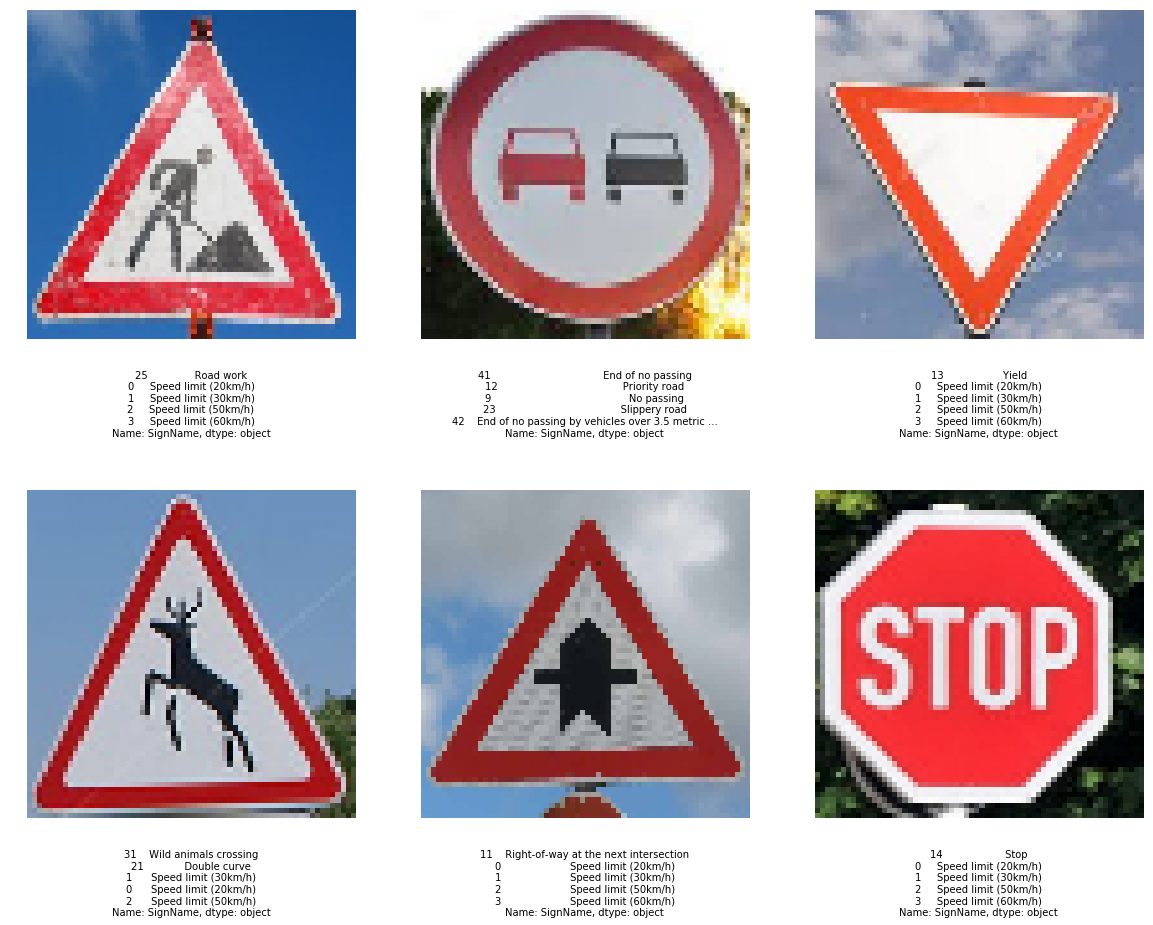

In [176]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Run the predictions here and use the model to output the prediction for each image.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('models/'))
    imgProcessed = imgProcessed.reshape(1, 32, 32, 3)
    top = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x : webSignsX})
    print('Predicted Signs are: ')
    print(*top.indices, sep = ', ')

plt.figure(figsize=(20, 25))
subPlotNum = 331
print('\n\nBelow are the images and their predictions')
for i in range(1,7):
    img = mpimg.imread('data/Sign' + str(i) + '.tiff')
    img = img[:,:,0:3]
    img = skimage.transform.resize(img, (64, 64), preserve_range= False, mode='reflect')
    ax = plt.subplot(subPlotNum)
    plt.imshow(img)
    plt.text(0.5, -0.2, signNames.SignName.iloc[top.indices[i-1:i][0]], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.axis('off')
    subPlotNum += 1

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="documentation/visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [177]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")